In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2


In [2]:
from fastai.vision import *
import seaborn as sns
from bw_detector import detect_color_image
from tqdm import tqdm
import itertools
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import cpu_count


In [3]:
# make sure you're running save version. fastai is beyond picky wrt version compatibility
from fastai.utils.collect_env import *
show_install()



```text
=== Software === 
python        : 3.6.8
fastai        : 1.0.45
fastprogress  : 0.1.19
torch         : 1.0.1.post2
nvidia driver : 410.57
torch cuda    : 10.0.130 / is available
torch cudnn   : 7402 / is enabled

=== Hardware === 
nvidia gpus   : 2
torch devices : 2
  - gpu0      : 10989MB | GeForce RTX 2080 Ti
  - gpu1      : 10981MB | GeForce RTX 2080 Ti

=== Environment === 
platform      : Linux-4.17.11-x86_64-with-debian-stretch-sid
distro        : #1 SMP Sun Jul 29 09:31:55 CEST 2018
conda env     : base
python        : /home/antor/miniconda3/bin/python
sys.path      : /home/antor/miniconda3/lib/python36.zip
/home/antor/miniconda3/lib/python3.6
/home/antor/miniconda3/lib/python3.6/lib-dynload

/home/antor/.local/lib/python3.6/site-packages
/home/antor/miniconda3/lib/python3.6/site-packages
/home/antor/miniconda3/lib/python3.6/site-packages/pytorch_colors-0.1.0-py3.6.egg
/home/antor/miniconda3/lib/python3.6/site-packages/IPython/extensions
/home/antor/.ipython
```

Please

In [4]:
defaults

namespace(cmap='viridis', cpus=32, device=device(type='cuda'), lr=slice(None, 0.003, None), wd=0.01)

In [5]:
path = Path('train')
fnames = get_image_files(path)

In [6]:
if False: # change to detect BW images (takes a while)
    def detect_bw_images(fns):
        bw = []
        for fn in fns:
            if not detect_color_image(fn): bw.append(fn)
        return bw

    with ProcessPoolExecutor(max_workers=cpu_count()) as e:
        bws = list(itertools.chain(*e.map(detect_bw_images, np.array_split(fnames, cpu_count()))))
    print(f"{100*len(bws)/len(fnames):0.02f}% of training images were grayscale")
    open_image(bws[2])
    for fn in tqdm(bws):
        fn.rename(fn.with_suffix('.bw'))

In [8]:
def rgb_to_hsv(rgb):
    i = rgb.px if isinstance(rgb,Image) else rgb
    hsv=torch.empty_like(i)
    mx = torch.max(i, dim=0)
    mn = torch.min(i, dim=0)
    r,g,b = i[0],i[1],i[2]
    df = mx[0]-mn[0]
    hh = torch.zeros((3,*i.shape[1:]),dtype=i.dtype, device=i.device)
    hh[0] = (60 * ((g-b)/df) + 360) % 360
    hh[1] = (60 * ((b-r)/df) + 120) % 360
    hh[2] = (60 * ((r-g)/df) + 240) % 360
    hsv[0] = hh.view(3,-1).gather(0,mx[1].view(1,-1)).view(i.shape[1:]) / 360.
    hsv[0][df==0]=0
    hsv[1] = (df/mx[0])
    hsv[1][mx[0]==0] = 0
    hsv[2] = mx[0]
    return Image(hsv)

def hsv_to_rgb(i):
    hsv = i.px if isinstance(i,Image) else i
    ii = (hsv[0] * 6).long()
    h,s,v=hsv[0],hsv[1],hsv[2]
    f = (h*6.)-ii.type(hsv.dtype)
    p,q,t = v*(1.-s), v*(1.-s*f), v*(1.-s*(1.-f))
    cc = lambda *xs: torch.cat([x.unsqueeze(0) for x in xs], dim=0)
    r = cc(v,q,p,p,t,v).view(6,-1).gather(0, ii.view(1,-1)).view(*hsv.shape[1:])
    g = cc(t,v,v,q,p,p).view(6,-1).gather(0, ii.view(1,-1)).view(*hsv.shape[1:])
    b = cc(p,p,t,v,v,q).view(6,-1).gather(0, ii.view(1,-1)).view(*hsv.shape[1:])
    return Image(cc(r,g,b))

In [9]:
mode = "YCbCr" 
if mode == "YCbCr":
    def get_colors(fn): return Image(open_image(fn, convert_mode="YCbCr").data[1:,...])
    def get_brightness(fn): return Image(open_image(fn, convert_mode="YCbCr").data[:1,...].expand(3,-1,-1))
    def get_image(brightness, colors=None):
        _y = (brightness.px[:1,...].cpu().numpy()*255).astype(np.uint8)
        if colors is None:
            yCbCr = np.concatenate([_y, _y, _y], axis=0)
        else:
            yCbCr = np.concatenate([_y, (colors.px[:,...].cpu().numpy()*255).astype(np.uint8)], axis=0)
        yCbCr = np.transpose(yCbCr, (1,2,0))
        return PIL.Image.fromarray(yCbCr, mode='YCbCr' if colors is not None else 'RGB')
    cc_loss = MSELossFlat(axis=1)
    
elif mode == "HSV":
    def get_rgb(fn, convert_mode='RGB'):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        rgb = PIL.Image.open(fn).convert(convert_mode)
        return pil2tensor(rgb,np.float32).div_(255)
    def get_colors(fn):     return Image(rgb_to_hsv(get_rgb(fn)).px[:2])
    def get_brightness(fn): return Image(rgb_to_hsv(get_rgb(fn)).px[2:].expand(3,-1,-1))
    def get_image(brightness, colors=None):
        v = brightness.px if isinstance(brightness, Image) else brightness
        if colors is None:
            rgb = Image(v.expand(3,-1,-1))
        else:
            hs = colors.px if isinstance(colors, Image) else colors
            rgb = hsv_to_rgb(Image(torch.cat((hs,v), dim=0)))
        np_rgb = np.transpose(rgb.px.cpu().numpy()*255, (1,2,0)).astype(np.uint8)
        return PIL.Image.fromarray(np_rgb, mode='RGB')
    class HVLoss(torch.nn.Module):

        __constants__ = ['reduction']

        def __init__(self, size_average=None, reduce=None, reduction='mean'):
            super(HVLoss, self).__init__()
            self.reduction = reduction

        def forward(self, input, target):
            return ((torch.fmod(input[:,0,...]-input[:,0,...]+0.5,1)-0.5)**2).mean() + F.mse_loss(input[:,1,...], target[:,1,...], reduction=self.reduction)
    cc_loss = HVLoss()
    
class MySegmentationProcessor(PreProcessor):
    "`PreProcessor` that stores the classes for segmentation."
    def __init__(self, ds:ItemList): pass
    def process(self, ds:ItemList):  pass
    

class MySegmentationLabelList(SegmentationLabelList):
    "`ItemList` for segmentation masks."
    _processor=MySegmentationProcessor
    def __init__(self, items:Iterator, **kwargs):
        super().__init__(items, **kwargs)
        self.loss_func = cc_loss

    def open(self, fn): return get_colors(fn)
    def analyze_pred(self, pred): return pred
    def reconstruct(self, t:Tensor): return ImageSegment(t)

In [10]:
class MySegmentationItemList(SegmentationItemList):
    _label_cls,_square_show_res = MySegmentationLabelList,False
    def open(self,fn): return get_brightness(fn)
    def show_xys(self, xs, ys, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show the `xs` (inputs) and `ys` (targets) on a figure of `figsize`."
        rows = int(np.ceil(math.sqrt(len(xs))))
        axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize)
        for x,y,ax in zip(xs, ys, axs.flatten()):
            ax.imshow( get_image(x, y))
        for ax in axs.flatten()[len(xs):]: ax.axis('off')
        plt.tight_layout()
    def show_xyzs(self, xs, ys, zs, imgsize:int=8, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`."
        title = 'Ground truth/Grayscale Input/Colorized predictions'
        axs = subplots(len(xs), 3, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=14)
        for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
            axs[i,0].imshow(get_image(x,y))
            axs[i,1].imshow(get_image(x))
            axs[i,2].imshow(get_image(x,z))
        for ax in axs.flatten()[len(xs):]: ax.axis('off')


In [11]:
src = MySegmentationItemList.from_folder(path).random_split_by_pct(0.2).label_from_func(lambda x:x)

In [12]:
size = 224
bs = 24//2
data = (src.transform(get_transforms(max_lighting=None,xtra_tfms=rand_resize_crop(size)), size=size, tfm_y=True,)
        .databunch(bs=bs)
        .normalize())
data.c=2

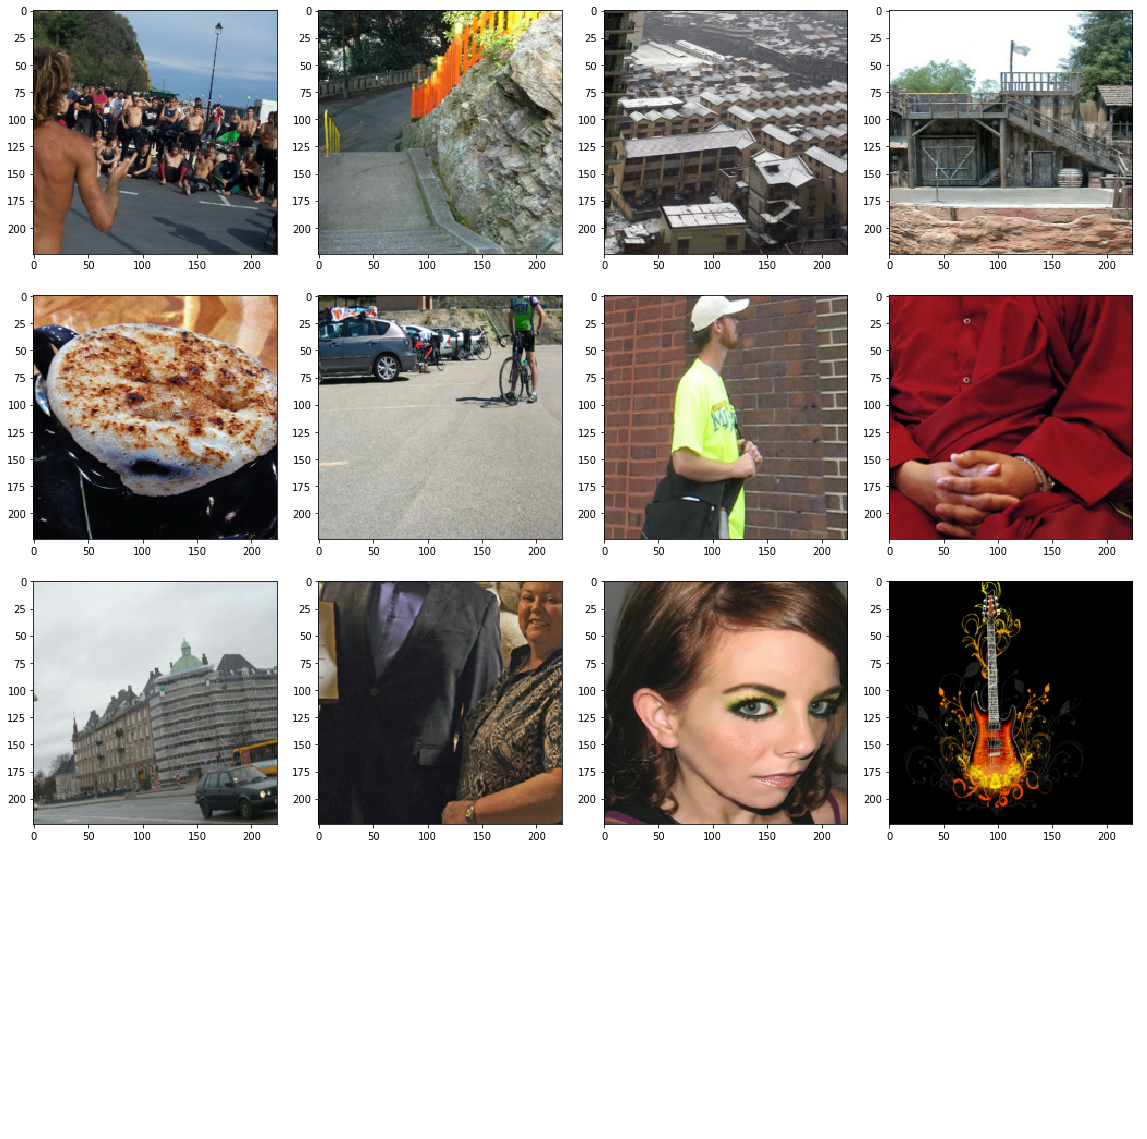

In [13]:
data.show_batch(20)


In [14]:
learn = unet_learner(data, models.resnet34, blur_final=False, y_range=(0,1.))
learn.unfreeze()

In [15]:
learn.load('w1')
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [1, 64, 112, 112]    9,408      True      
______________________________________________________________________
BatchNorm2d          [1, 64, 112, 112]    128        True      
______________________________________________________________________
ReLU                 [1, 64, 112, 112]    0          False     
______________________________________________________________________
MaxPool2d            [1, 64, 56, 56]      0          False     
______________________________________________________________________
Conv2d               [1, 64, 56, 56]      36,864     True      
______________________________________________________________________
BatchNorm2d          [1, 64, 56, 56]      128        True      
______________________________________________________________________
ReLU                 [1, 64, 56, 56]      0          False     
______________________________________________________________

# Skip to inference if you do not want to train

In [ ]:
lr_find(learn)
lr = learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1,max_lr=1e-3)

In [ ]:
learn.save('w1', return_path=True)

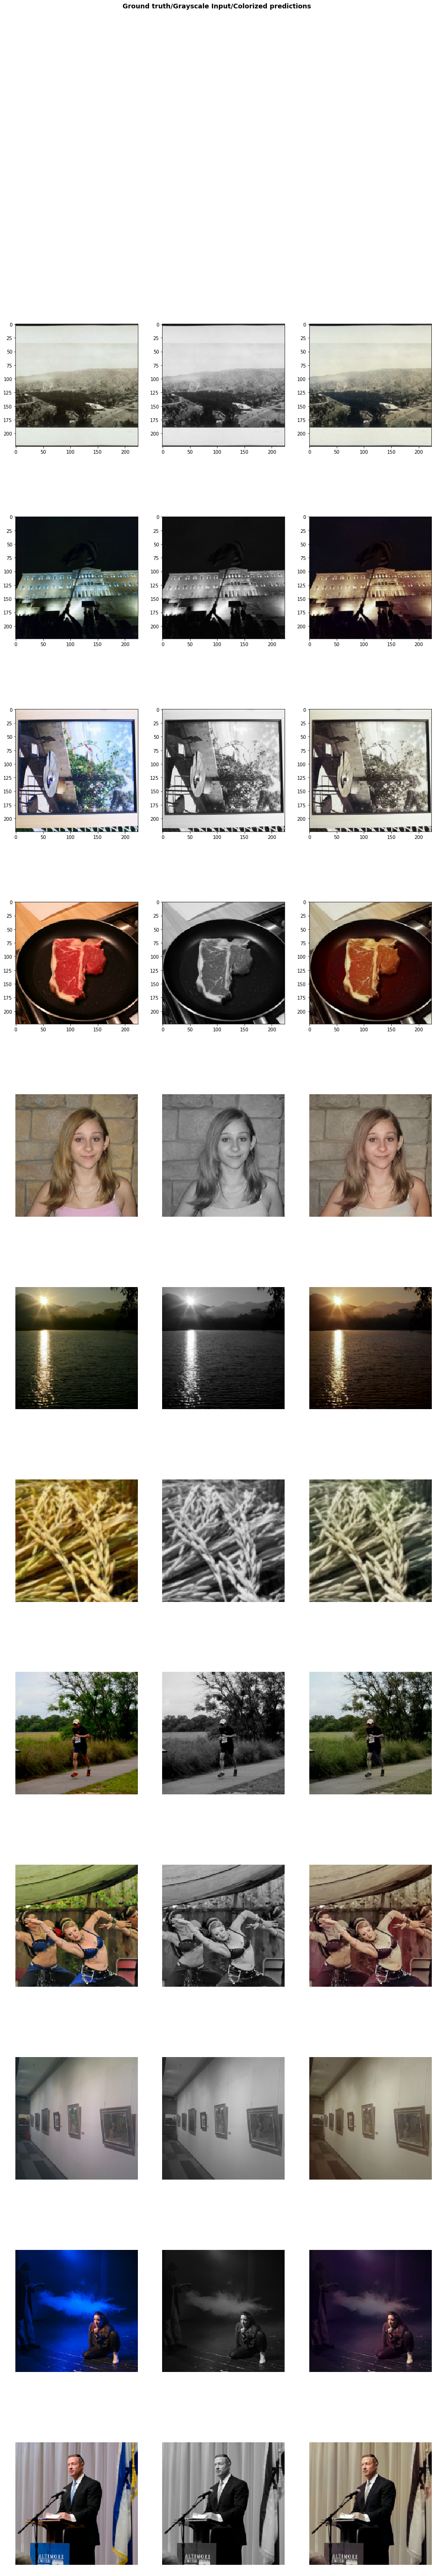

In [16]:
learn.show_results(rows=20, figsize=(16,9*10))

# Inference

In [18]:
#y = get_Y('test/schindler.png')
y = get_y('gwtw.jpg')
cbcr = Image(learn.predict(y.clone().resize(size))[1])
yCbCr = torch.cat([y.data[:1],cbcr.resize((2,y.shape[1],y.shape[2])).data])
np_yCbCr = np.transpose((yCbCr.cpu().numpy()*255).astype(np.uint8), (1,2,0))


NameError: name 'get_y' is not defined

In [ ]:
y

In [ ]:
colorized = PIL.Image.fromarray(np_yCbCr, mode='YCbCr')
plt.imshow(colorized)

In [ ]:
colorized.save('twc.jpg')